# Simulation of Markov Chain Monte Carlo (MCMC) Sampling Methods and Their Application in Text Classification

##### Kruthikesh M Kopparam

I chose this topic because I wanted to explore the intersection of probabilistic sampling methods and practical machine learning applications. MCMC methods are powerful tools for approximating complex distributions that arise in real-world problems, especially when exact computations are infeasible. The idea of using these methods in text classification—like spam detection—where traditional techniques may struggle with scalability and uncertainty, intrigued me and motivated this project.

MCMC techniques like Metropolis-Hastings and Gibbs sampling have been foundational in Bayesian inference and probabilistic modeling. In the context of multimodal learning, where different data types (e.g., text, images, audio) are integrated, probabilistic sampling is crucial for handling uncertainty and combining modalities effectively.

Through this project, I gained a deep understanding of how MCMC algorithms work, particularly the principles of stationary distribution and detailed balance. I learned to implement and simulate Metropolis and Gibbs sampling, and understood their theoretical underpinnings. Applying Gibbs sampling to text classification helped me appreciate how probabilistic models can be tailored to real data, and how computational optimizations like vectorization significantly improve performance. Overall, this project enhanced both my theoretical foundation and practical skills in probabilistic machine learning.

### What are MCMC algorithms 

It is a sampling method which is used to sample the target distribution given some information about it (a function which is directly proportional to it or the conditional distribution).
It is called markov chain because the next sample depends on current sample and monte carlo because we simulate samples from the target distribution by simulating Markov chain. We let the Markov Chain grow and eventually, it draws samples from target distribution.
For this algorithm we need to know what stationary distribution is, a stationary distribution of a Markov chain is a probability distribution that remains unchanged in the Markov chain as time progresses.

A sufficient condition for the Markov chain to converge to the stationary distribution p(x) is that they satisfy the condition of detailed balance p(i)T(ij) = p(j)T(ji) for all i,j.  
Tij-> transition probability to state j from state i

In [3]:
import re
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from numpy.random import beta, binomial, dirichlet

## METROPOLIS ALGORITHM DEMO

Algorithm:

1) Pick an initial state x at random.

2) Sample from the proposal distibution as x~q(x'|x).

3) Accept with probability min(1,(p(x')q(x|x'))/(p(x)q(x'|x))).

4) If rejected, the next state is a repeat of the current state.

5) Iterate step 2 to 4.

#### PROOF FOR THE ALGORITHM

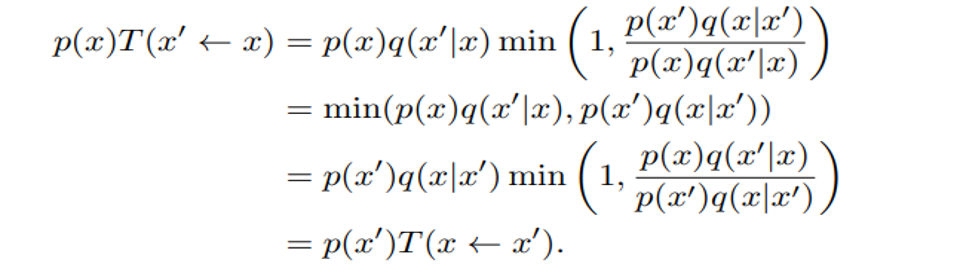

#### Detailed Balance Condition Holds! Hence p(x) is the required stationary distribution.

In [4]:
def return_proportional_value(x,a,b):
    return x**(a-1)*(1-x)**(b-1)
def metropolis_beta_distribution(a,b):
    points_accepted = []
    number_of_iterations = 10000
    prev = np.random.rand()

    for _ in range(number_of_iterations):
        curr = max(0.00001, min(0.99999, np.random.normal(prev, 0.1))) #Sample new point given old point
        # Calculate the ‘acceptance_probability’ using the expression as stated in the algorithm and accept it with the same probability.
        acceptance_probab = min(1,(return_proportional_value(curr,a,b)/return_proportional_value(prev,a,b)))

        if np.random.rand() < acceptance_probab:
            prev = curr
        # Append the point to the array.
        points_accepted.append(prev)

    points_accepted = np.array(points_accepted)
    
    x = np.linspace(0, 1, 10000)
    y =  beta(a,b)*x**(a-1) * (1-x)**(b-1) #Using the inbuilt function in python. Get the actual distribution from this.
    fig, axs = plt.subplots(2)
    
    axs[0].plot(x, y)
    axs[0].set_title(f'Beta function for a = {a}, b = {b}')

    burn_in = 0.3
    axs[1].hist(points_accepted[int(burn_in*number_of_iterations):], bins = 100)
    axs[1].set_title('Using Metropolis Algorithm')
    plt.tight_layout()
    plt.show()

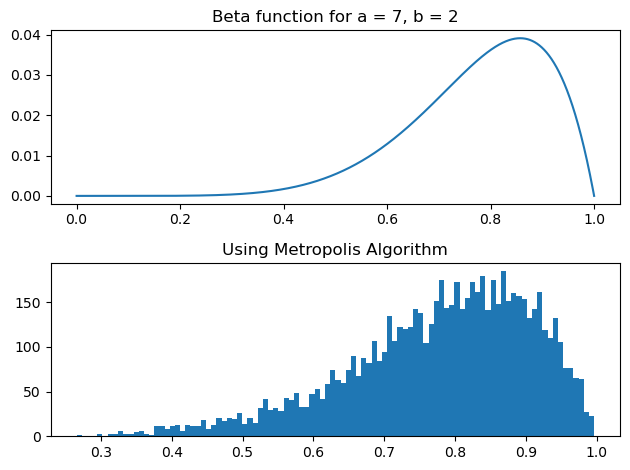

In [5]:
a = 7
b = 2
metropolis_beta_distribution(a,b)

In [82]:
def tic():
    global start_time
    start_time = time.time()

def toc():
    if 'start_time' in globals():
        elapsed_time = time.time() - start_time
        print("Elapsed time:", elapsed_time, "seconds")
    else:
        print("Toc: start_time not set")
    return elapsed_time

## GIBBS ALGORITHM

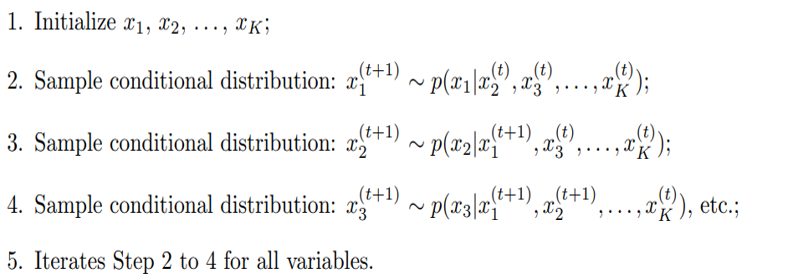

It can be viewed as a Metropolis-Hastings method in which a sequence of proposal distributions q(x|x0) are defined in terms of the conditional distributions of the joint distribution p(x) (and the acceptance probabilities becomes one). It is assumed that, whilst p(x) is too complex to draw samples from directly, its conditional distributions p(xi |xj!=i) are tractable to work with. (Substitute p(x) = p(x,x’) and q(x’|x) = p(x’|x) = p(x’,x)/NC).

### APPLICATION OF GIBBS ALGORITHM IN TEXT CLASSIFICATION

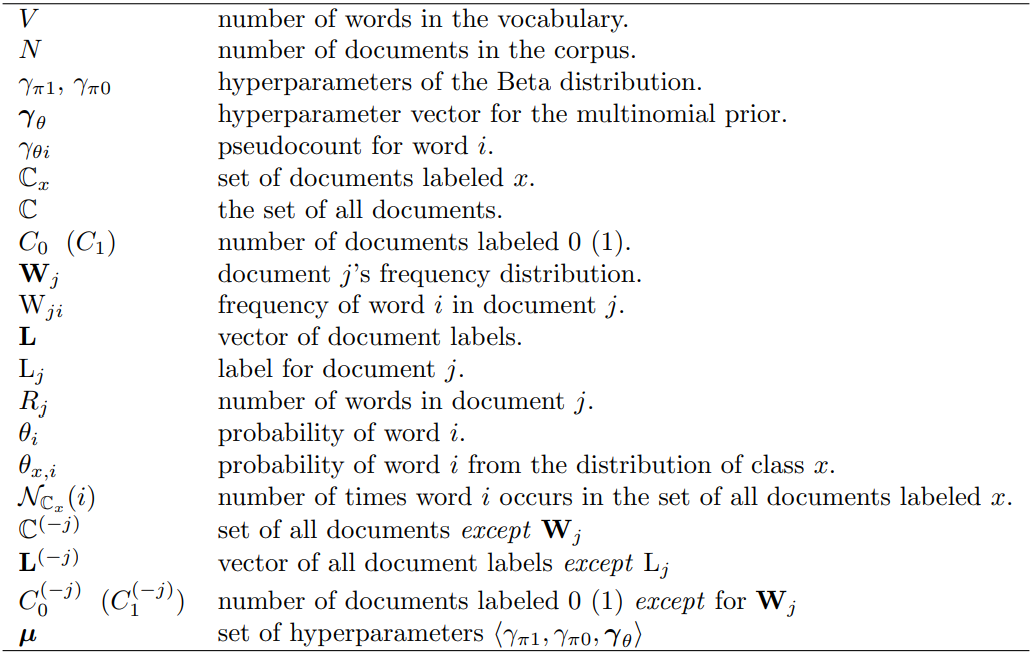

#### Final pdf from which we are sampling the label and theta (the proof for which is available in the paper attached in the repository)

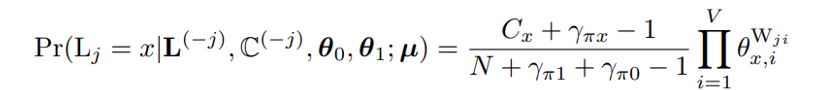

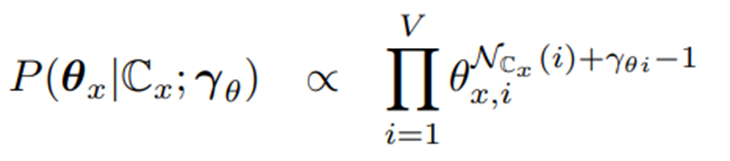

In [83]:
def read_data(path='./spam-or-ham.txt'):
    fp = open(path, 'r', encoding='utf-8')
    texts = []
    labels = []
    for line in fp:
        line = line.strip()
        if line:
            label, text = line.split('\t')
            labels.append(label)
            texts.append(text)
    fp.close()
    # print(texts)    
    return texts, labels

In [84]:
texts, labels = read_data()

In [85]:
def get_freqs(texts):
    freq = {}
    W_mapping = {}
    for text in texts:
        for word in text.split():
            temp_word = re.sub(r'\W+','', word)
            temp_word = temp_word.lower()
            if (temp_word in freq):
                freq[temp_word] += 1
            else:
                freq[temp_word] = 1
    mp=0
    
    freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))
    freq[''] = 0 #We dont want empty strings as words in our data
    freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))
    
    W_freqs = []
    for word in islice(freq.keys(), 10000):
        W_mapping[word] = mp
        mp += 1

    for text in texts:
        temp_freq = {}  
        for word in text.split():
            temp_word = re.sub(r'\W+','', word)
            temp_word = temp_word.lower()
            if (temp_word in W_mapping.keys() and W_mapping[temp_word] in temp_freq):
                temp_freq[W_mapping[temp_word]] += 1
            elif(temp_word in W_mapping.keys()):
                temp_freq[W_mapping[temp_word]] = 1
        W_freqs.append(temp_freq)
    return W_freqs, W_mapping

In [86]:
W_freqs, W_mapping = get_freqs(texts)

Explanation for the Code Below:

1) Hyperparameters are constant in the entire code and are used only to initialize the parameters (labels and theta).

2) ‘n’ contains the fraction of emails to be used as training data.

3) ‘Sample_mails’ contains the information about mails to be sampled as spam or not.

4) ‘count_label_word_freqs’ contains the frequency of a word in a particular class.(For both data and the emails to be sampled).

5) ‘count_spams_hams’ contains the number of emails which are spam and which are not.(For both data and the emails to be sampled).

In [87]:
no_of_mails = len(W_freqs)
p = 0.3
n = (int)(p*no_of_mails)
#INITIALIZE
def initialize(W_freqs, W_mapping):
    
    known_labels = np.array([0 if x=="ham" else 1 for x in labels[:n]])
    vocab = len(W_mapping)

    #HYPERPARAMETERS
    gamma_pi = (1, 1)
    gamma_theta = [1]*vocab
    pi = beta(gamma_pi[0], gamma_pi[1])

    #PARAMETERS INITIALISATION
    sampled_labels = binomial(1, pi, no_of_mails-n)
    sampled_theta = dirichlet(gamma_theta, 2)

    sample_mails = W_freqs[n:]
    count_spams_hams = np.ones((2))
    count_label_word_freqs = np.ones((2, vocab))#since this is a parameter for dirichlet function it cant be zeroes hence all of them are given a count of one 

    for i in range(0,len(sample_mails)):
        count_spams_hams[sampled_labels[i]] += 1
        for key in sample_mails[i]:
            count_label_word_freqs[sampled_labels[i]][key] += sample_mails[i][key]

    for i in range(0,n):
        count_spams_hams[known_labels[i]] += 1
        for key in W_freqs[i]:
            count_label_word_freqs[known_labels[i]][key] += W_freqs[i][key]
   
    return sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams


In [88]:
sampled_labels,sampled_theta,sample_mails,count_label_word_freqs,count_spams_hams = initialize(W_freqs, W_mapping)

Explanation for the Code Below:

1) The information about the mail to be sampled is not considered for sampling its label.

2) After which the probability expression which was evaluated in previous slides is being used.

3) I have calculated the log of the expression since the code would have been simpler and the probabilities or weights have been normalised with respect to the maximum to avoid very small(almost 0) or very large values(order of 10).

4) The information about the sample label is then updated.

5) The theta’s are also sampled taking into consideration the updated information.

In [89]:
def update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams):

    for j, l in enumerate(sampled_labels):
        
        for key in sample_mails[j]: 
            count_label_word_freqs[l][key] -=  sample_mails[j][key]
            
        count_spams_hams[l] -= 1
        d = len(count_spams_hams)+2
        v0 = np.log((count_spams_hams[0]+1) / d)
        v1 = np.log((count_spams_hams[1]+1) / d)
        for key in sample_mails[j]:
            v0 += sample_mails[j][key] * np.log(sampled_theta[0,key])
            v1 += sample_mails[j][key] * np.log(sampled_theta[1,key])
            
        m = max(v0, v1)
        log_sum_exp = m + np.log(np.exp(v0 - m) + np.exp(v1 - m))
        v0 = np.exp(v0 - log_sum_exp)
        v1 = np.exp(v1 - log_sum_exp)
        new_label = random.choices([1, 0], weights=[v1, v0])[0]
        
        sampled_labels[j] = new_label
        count_spams_hams[new_label] += 1
        
        for key in sample_mails[j]: 
            count_label_word_freqs[new_label][key] += sample_mails[j][key]

    # print(count_label_word_freqs[0])
    sampled_theta[0] = dirichlet(count_label_word_freqs[0])
    sampled_theta[1] = dirichlet(count_label_word_freqs[1])

    return sampled_labels,sampled_theta

In [90]:
def vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams):
    for j, l in enumerate(sampled_labels):
        
        keys = np.array(list(sample_mails[j].keys())).astype(int)
        values = np.array(list(sample_mails[j].values()))
        count_label_word_freqs[l][keys] -= values
        count_spams_hams[l] -= 1
        
        d = len(count_spams_hams) + 2
        v0 = np.log((count_spams_hams[0] + 1) / d)
        v1 = np.log((count_spams_hams[1] + 1) / d)
        
        theta_0 = np.log(sampled_theta[0][keys])
        theta_1 = np.log(sampled_theta[1][keys])

        v0 += np.sum(values * theta_0)
        v1 += np.sum(values * theta_1)
        
        m = np.maximum(v0, v1)
        log_sum_exp = m + np.log(np.exp(v0 - m) + np.exp(v1 - m))
        v0 = np.exp(v0 - log_sum_exp)
        v1 = np.exp(v1 - log_sum_exp)
        
        new_label = random.choices([1, 0], weights=[v1, v0])[0]
        sampled_labels[j] = new_label
        count_spams_hams[new_label] += 1
        
        count_label_word_freqs[new_label][keys] += values

    sampled_theta[0] = dirichlet(count_label_word_freqs[0])
    sampled_theta[1] = dirichlet(count_label_word_freqs[1])

    return sampled_labels, sampled_theta

In [ ]:
#Run this cell if you want to use the function without vectorisation

no_of_iters = 100
tic()
for _ in range(0,no_of_iters):
    sampled_labels, sampled_theta = update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    
toc()
correct_sample = 0

for i in range(n,no_of_mails):
    if sampled_labels[i-n] == 0 and labels[i] == 'ham' or sampled_labels[i-n] == 1 and labels[i] == 'spam':
        correct_sample += 1
        
print((correct_sample/(no_of_mails-n)))

In [ ]:
#Run this cell if you want to use the function with vectorisation

no_of_iters = 500
tic()
for _ in range(0,no_of_iters):
    sampled_labels, sampled_theta = vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    
toc()
correct_sample = 0

for i in range(n,no_of_mails):
    if sampled_labels[i-n] == 0 and labels[i] == 'ham' or sampled_labels[i-n] == 1 and labels[i] == 'spam':
        correct_sample += 1

print((correct_sample/(no_of_mails-n)))

Elapsed time: 37.099687814712524 seconds
Elapsed time: 9.565616607666016 seconds
Elapsed time: 391.0334589481354 seconds
Elapsed time: 71.1022481918335 seconds
Elapsed time: 749.9435081481934 seconds
Elapsed time: 141.51111245155334 seconds
Elapsed time: 1315.9844257831573 seconds
Elapsed time: 235.52190375328064 seconds
Elapsed time: 2293.548369407654 seconds
Elapsed time: 403.8968963623047 seconds


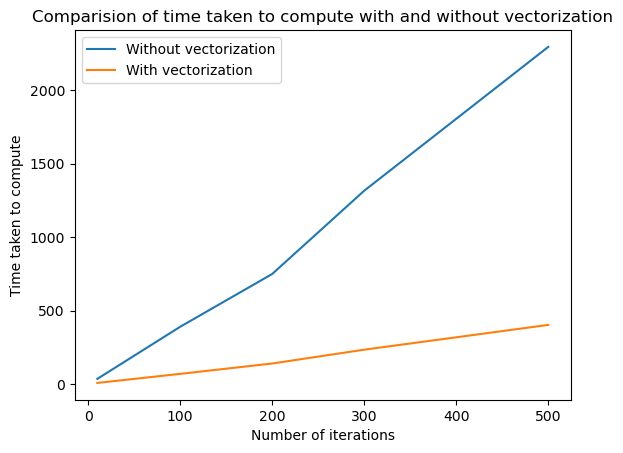

In [120]:
#Time analysis with and without vectorisation

array_of_number_of_iters = [10, 100, 200, 300, 500]
time_taken_without_vectorization = []
time_taken_with_vectorization = []
for num_of_iters in array_of_number_of_iters:
    tic()
    for _ in range(0,num_of_iters):
        sampled_labels, sampled_theta = update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    time_to_append = toc()
    time_taken_without_vectorization.append(time_to_append)
    
    tic()
    for _ in range(0,num_of_iters):
        sampled_labels, sampled_theta = vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    time_to_append1 = toc()
    time_taken_with_vectorization.append(time_to_append1)
    
plt.plot(array_of_number_of_iters, time_taken_without_vectorization, label='Without vectorization')
plt.plot(array_of_number_of_iters, time_taken_with_vectorization, label='With vectorization')

plt.xlabel('Number of iterations')
plt.ylabel('Time taken to compute')
plt.title('Comparision of time taken to compute with and without vectorization')
plt.legend()

plt.show()

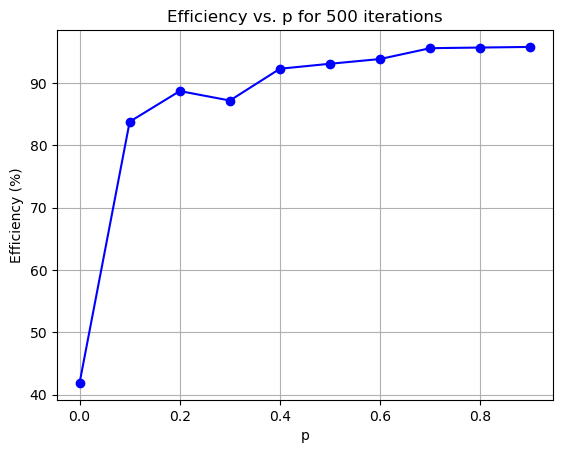

In [29]:
# num of iters = 500
# p=0-> 41.9
# p=0.1->83.8
# p=0.2->88.72
# p=0.3->87.2
# p=0.4->92.3
# p=0.5->93.1
# p=0.6->93.86
# p=0.7->95.6
# p=0.8->95.7
# p=0.9->95.8

#The data is generated by running the vectorized function for the below percentage of data documents.
p_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
efficiency_values = [41.9, 83.8, 88.72, 87.2, 92.3, 93.1, 93.86, 95.6, 95.7, 95.8]

plt.plot(p_values, efficiency_values, marker = 'o', color = 'b', linestyle = '-')

plt.xlabel('p')
plt.ylabel('Efficiency (%)')
plt.title('Efficiency vs. p for 500 iterations')

plt.grid(True)

plt.show()

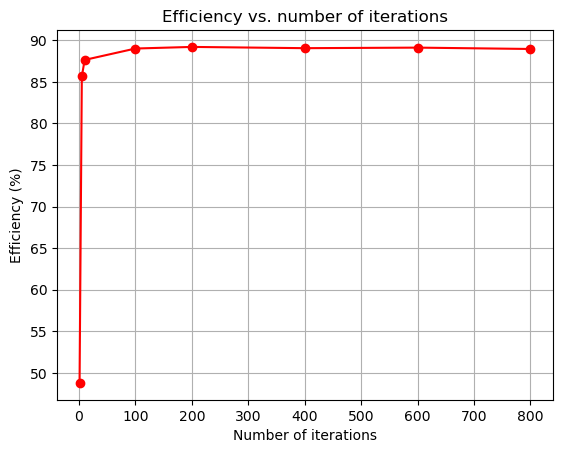

In [91]:
no_of_iters_array = [1, 4, 5, 90, 100, 200, 200, 200]
efficiency = []
for i in no_of_iters_array:
    no_of_iters = i
    for _ in range(0,no_of_iters):
        sampled_labels, sampled_theta = vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
        
    correct_sample = 0
    
    for i in range(n,no_of_mails):
        if sampled_labels[i-n] == 0 and labels[i] == 'ham' or sampled_labels[i-n] == 1 and labels[i] == 'spam':
            correct_sample += 1
    
    efficiency.append((correct_sample/(no_of_mails-n))*100)
                      

x_axis = [1, 5, 10, 100, 200 , 400, 600, 800]
            
plt.plot(x_axis, efficiency, marker = 'o', color = 'r', linestyle = '-')

plt.xlabel('Number of iterations')
plt.ylabel('Efficiency (%)')
plt.title('Efficiency vs. number of iterations')

plt.grid(True)

plt.show()